In [ ]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from UNet import UNet
from calculate import DiceLoss, calculate_metrics  # 假设calculate_metrics已被正确定义

# 自定义数据集
class MaskDataset(Dataset):
    def __init__(self, label_dir, mask_dir, transform=None):
        self.label_dir = label_dir
        self.mask_dir = mask_dir
        self.transform = transform
        # 筛选出以 '.png' 结尾的文件
        self.filenames = [f for f in os.listdir(label_dir) if f.endswith('.png')]

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        label_path = os.path.join(self.label_dir, self.filenames[idx])
        mask_path = os.path.join(self.mask_dir, self.filenames[idx])
        
        # 加载标签和掩膜图像，检查是否成功加载
        label = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        label = label / 255.0  # 归一化
        mask = mask / 255.0    # 归一化

        if self.transform:
            label = self.transform(label)
            mask = self.transform(mask)

        label = torch.tensor(label, dtype=torch.float32).unsqueeze(0)  # 增加一个维度
        mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)    # 增加一个维度
        return mask, label

# 训练函数
def train_unet(model, train_loader, test_loader, num_epochs, device, scheduler=None):
    criterion_dice = DiceLoss()  # 使用 Dice Loss
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    train_losses, test_losses = [], []
    best_dice_score = -1.0  # 用于保存最佳模型
    best_model_wts = None

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for mask, label in train_loader:
            mask, label = mask.to(device), label.to(device)
            optimizer.zero_grad()
            output = model(mask)
            loss = criterion_dice(output, label)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        # 验证
        model.eval()

        acc = 0.0
        total = 0
        iou_total = 0.0
        dice_total = 0.0
        f1_total = 0.0
        val_loss = 0.0  # 验证集损失
        current_dice_score = 0.0  # 当前验证集上的 Dice 得分
        with torch.no_grad():
            for test_image, test_label in test_loader:
                outputs = model(test_image.to(device))
                preds = torch.sigmoid(outputs)
                preds = (preds > 0.5).float()  # 0.5阈值

                if test_label.dim() == 3:
                    test_label = test_label.unsqueeze(1).float()
                elif test_label.dim() == 4:
                    test_label = test_label.float()

                # 计算损失
                loss = criterion_dice(outputs, test_label.to(device))
                val_loss += loss.item()

                # 计算评估指标
                iou_score, dice_score, precision, recall, f1 = calculate_metrics(preds.cpu(), test_label.cpu())

                # 累加各项指标
                iou_total += iou_score
                dice_total += dice_score
                f1_total += f1

                # 计算准确率
                acc += torch.sum(torch.eq(preds, test_label.to(device))).item() / (test_label.size(2) * test_label.size(3))
                total += test_label.size(0)

            # 计算平均准确率和损失
            accurate = acc / total
            avg_val_loss = val_loss / len(test_loader)
            avg_iou = iou_total / len(test_loader)
            avg_dice = dice_total / len(test_loader)
            avg_f1 = f1_total / len(test_loader)

            # 更新最佳模型
            if avg_dice > best_dice_score:
                best_dice_score = avg_dice
                best_model_wts = model.state_dict()  # 保存当前最佳模型的权重

            # 打印训练和验证的损失、准确率、F1分数、Precision、Recall、IoU和Dice
            print(f"[epoch {epoch + 1}] val_loss: {avg_val_loss:.3f} val_accuracy: {accurate * 100:.3f}%")
            print(f"IoU: {avg_iou:.3f}, Dice: {avg_dice:.3f}, F1 Score: {avg_f1:.3f}, Precision: {precision:.3f}, Recall: {recall:.3f}")

        # 更新学习率
        if scheduler:
            scheduler.step(avg_dice)  # 如果是 ReduceLROnPlateau, 基于 Dice 进行学习率调整

    # 恢复最好的模型
    if best_model_wts:
        model.load_state_dict(best_model_wts)

    # 保存最佳模型
    torch.save(model.state_dict(), "best_repair_model.pth")
    print("Best model saved as best_repair_model.pth")

    return model, train_losses, test_losses

# 数据路径
label_dir = "new2/masks"
mask_dir = "lack"

# 数据加载
dataset = MaskDataset(label_dir, mask_dir)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

# 初始化模型
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(1, 1).to(device)

# 学习率衰减器（每当验证的Dice得分不再提升时，学习率减少）
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(torch.optim.Adam(model.parameters(), lr=1e-4), 
                                                        mode='max', 
                                                        factor=0.1, 
                                                        patience=3, 
                                                        verbose=True)

# 训练模型
num_epochs = 20
model, train_losses, test_losses = train_unet(model, train_loader, test_loader, num_epochs, device, scheduler)

# 显示一张修复结果
model.eval()
with torch.no_grad():
    mask, label = test_dataset[0]  # 取第一张测试图像
    mask = mask.unsqueeze(0).to(device)  # 增加 batch 维度
    output = model(mask)
    output = torch.sigmoid(output).squeeze().cpu().numpy()  # Sigmoid 激活并去掉 batch 维度

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.title("Mask")
plt.imshow(mask.cpu().squeeze(), cmap="gray")
plt.subplot(1, 3, 2)
plt.title("Label")
plt.imshow(label.squeeze(), cmap="gray")
plt.subplot(1, 3, 3)
plt.title("Reconstructed")
plt.imshow(output, cmap="gray")
plt.show()


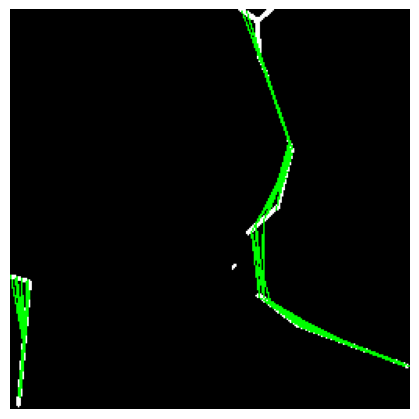

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 读取二值图像
image_path = "lack/11_mask_23.png"
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# 获取轮廓
contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# 定义计算像素值变化次数的函数
def count_pixel_changes(point, img):
    # 获取点的8邻域
    neighbors = [
        (point[0] - 1, point[1] - 1), (point[0], point[1] - 1), (point[0] + 1, point[1] - 1),
        (point[0] - 1, point[1]),                           (point[0] + 1, point[1]),
        (point[0] - 1, point[1] + 1), (point[0], point[1] + 1), (point[0] + 1, point[1] + 1)
    ]
    
    changes = 0
    for (x, y) in neighbors:
        if 0 <= x < img.shape[1] and 0 <= y < img.shape[0]:  # 确保在图像内
            if img[y, x] != img[point[1], point[0]]:  # 修改：索引顺序应为 img[y, x]
                changes += 1
    return changes

# 找到端点
endpoints = []
for contour in contours:
    for point in contour:
        x, y = point[0][0], point[0][1]  # 提取 x, y 坐标
        changes = count_pixel_changes((x, y), image)  # 传入 (x, y)
        if changes == 0 or changes == 2:  # 如果变化次数为0或2，认为是端点
            endpoints.append((x, y))

# 定义一个函数计算两点之间的欧氏距离
def euclidean_distance(p1, p2):
    return np.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

# 连接端点
threshold_distance = 50  # 设置连接端点的最大阈值距离
min_threshold_distance = 40
image_copy = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)  # 创建彩色图像用于绘制直线
for i in range(len(endpoints)):
    for j in range(i + 1, len(endpoints)):
        p1 = endpoints[i]
        p2 = endpoints[j]
        distance =euclidean_distance(p1, p2)
        if min_threshold_distance < distance <= threshold_distance:
            cv2.line(image_copy, p1, p2, (0, 255, 0), 1)  # 绿色直线连接端点

# 修改显示结果部分
plt.figure(figsize=(4, 4))  # 减小图片尺寸
plt.imshow(image_copy)
plt.axis('off')

# 完全移除所有边框和边距
plt.gca().set_position([0, 0, 1, 1])  # 设置轴位置占满整个图形
plt.margins(0, 0)
plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)



plt.show()

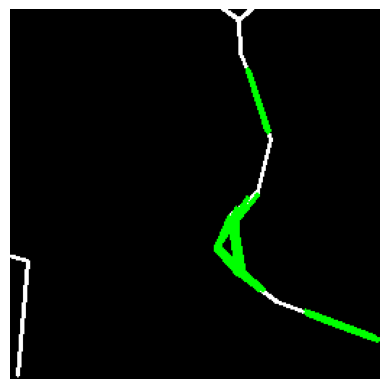

In [13]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 1. 加载图像并转换为灰度图像
image_path = "lack/11_mask_23.png"
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# 2. 将图像转换为二值图像
_, binary_image = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)

# 3. 查找轮廓
contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# 4. 找到每个轮廓的端点
def find_endpoints(contour):
    endpoints = []
    for i in range(len(contour)):
        pt1 = contour[i][0]
        pt2 = contour[(i + 1) % len(contour)][0]  # 下一个点（轮廓闭合）
        if np.linalg.norm(pt1 - pt2) > 1:  # 只有大于1的距离才被认为是端点
            endpoints.append(pt1)
    return endpoints

# 存储所有轮廓的端点
all_endpoints = []

for contour in contours:
    endpoints = find_endpoints(contour)
    all_endpoints.append(endpoints)

# 5. 连接端点：计算端点之间的距离，并在距离小于阈值时连接
def connect_endpoints(endpoints_list, threshold):
    connections = []
    for i in range(len(endpoints_list)):
        for j in range(i + 1, len(endpoints_list)):
            for p1 in endpoints_list[i]:
                for p2 in endpoints_list[j]:
                    distance = np.linalg.norm(np.array(p1) - np.array(p2))
                    if distance < threshold:
                        connections.append((p1, p2))  # 存储连接的端点对
    return connections

# 找到所有端点之间的连接
connections = connect_endpoints(all_endpoints, threshold=45)

# 6. 在原始图像上绘制连接
image_with_connections = cv2.cvtColor(binary_image, cv2.COLOR_GRAY2BGR)

# 绘制端点和连接
for connection in connections:
    cv2.line(image_with_connections, tuple(connection[0]), tuple(connection[1]), (0, 255, 0), 2)

# 7. 可视化结果
plt.imshow(image_with_connections)
plt.axis('off')

plt.show()


In [ ]:
import os
import cv2
import torch
import numpy as np
from UNet import UNet
import matplotlib.pyplot as plt

# 加载模型
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(1, 1).to(device)
model.load_state_dict(torch.load("best_repair_model.pth"))
model.eval()

# 读取图片
lack_image = cv2.imread("lack/11_mask_23.png", cv2.IMREAD_GRAYSCALE)
ground_truth = cv2.imread("new2/masks/11_mask_23.png", cv2.IMREAD_GRAYSCALE)

# 处理待修复的图片
image = lack_image / 255.0
image = torch.tensor(image, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
image = image.to(device)

# 进行修复
with torch.no_grad():
    output = model(image)
    output = torch.sigmoid(output).squeeze().cpu().numpy()

# 将输出转换回图片格式
repaired_image = (output * 255).astype(np.uint8)

# 找出修复的区域（原图是黑色但修复后是白色的区域）
repair_mask = np.zeros_like(lack_image)
repair_mask[(lack_image < 128) & (repaired_image > 128)] = 255

# 创建RGB图像用于显示绿色标记
original_rgb = cv2.cvtColor(lack_image, cv2.COLOR_GRAY2RGB)
repaired_rgb = cv2.cvtColor(repaired_image, cv2.COLOR_GRAY2RGB)

# 在修复区域添加绿色标记
repaired_with_highlight = repaired_rgb.copy()
repaired_with_highlight[repair_mask > 0] = [0, 255, 0]  # 绿色
cv2.imwrite('repaired_with_green_highlight.png', cv2.cvtColor(repaired_with_highlight, cv2.COLOR_RGB2BGR))
plt.figure(figsize=(15, 5))

# 显示原始缺陷图片
plt.subplot(131)
plt.imshow(lack_image, cmap='gray')
plt.title('Original Defect Image')
plt.axis('off')

# 显示修复后的图片（带绿色标记）
plt.subplot(132)
plt.imshow(repaired_with_highlight)
plt.title('Repaired Image (Green: Repaired Areas)')
plt.axis('off')

# 显示ground truth
plt.subplot(133)
plt.imshow(ground_truth, cmap='gray')
plt.title('Ground Truth')
plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
import os
import cv2
import torch
import numpy as np
from UNet import UNet
import matplotlib.pyplot as plt

# 加载模型
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(1, 1).to(device)
model.load_state_dict(torch.load("best_repair_model.pth"))
model.eval()

# 创建修复结果保存文件夹
repair_pic_dir = "base_repair_pic"
os.makedirs(repair_pic_dir, exist_ok=True)

# 加载图片并进行修复
aug_all_pic_dir = "base_all_pic"
image_filenames = [f for f in os.listdir(aug_all_pic_dir) if f.endswith('.png')]

for filename in image_filenames:
    image_path = os.path.join(aug_all_pic_dir, filename)
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = image / 255.0  # 归一化
    image = torch.tensor(image, dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # 增加 batch 和 channel 维度
    image = image.to(device)

    # 进行修复（推理）
    with torch.no_grad():
        output = model(image)
        output = torch.sigmoid(output).squeeze().cpu().numpy()  # Sigmoid 激活并去掉 batch 和 channel 维度

    # 将修复结果保存为图片
    output_image = (output * 255).astype(np.uint8)  # 恢复为[0, 255]范围的图像
    output_path = os.path.join(repair_pic_dir, filename)
    cv2.imwrite(output_path, output_image)

    print(f"Processed and saved {filename} to {repair_pic_dir}")

# 打印完成提示
print("All images processed and saved.")


In [ ]:
import os
import cv2
import numpy as np
from tqdm import tqdm  # 进度条库
import random

# 定义函数：随机生成缺失区域
def create_missing_regions(mask, num_circles=(5, 7), area_range=(250, 500)):
    """
    在白色区域上随机生成缺失区域（圆形）。
    Args:
        mask (numpy array): 输入的掩膜图像，二值图像 (0, 255)。
        num_circles (tuple): 缺失圆形的数量范围。
        area_range (tuple): 每个圆的面积范围。
    Returns:
        numpy array: 带有缺失区域的掩膜图像。
    """
    h, w = mask.shape
    result = mask.copy()

    # 将白色区域提取为候选区域
    white_coords = np.column_stack(np.where(mask == 255))
    
    if len(white_coords) == 0:
        return result  # 没有白色区域，直接返回

    for _ in range(random.randint(*num_circles)):
        # 随机选择一个圆心
        center = random.choice(white_coords)
        # 随机生成圆的半径
        area = random.uniform(*area_range)
        radius = int(np.sqrt(area / np.pi))

        # 在掩膜上绘制圆
        cv2.circle(result, tuple(center[::-1]), radius, 0, -1)  # 绘制黑色圆形，颜色为0
    
    return result

# 输入输出路径
input_dir = "new2/masks"
output_dir = "lack"
os.makedirs(output_dir, exist_ok=True)  # 如果输出文件夹不存在，创建它

# 遍历所有图片
for filename in tqdm(os.listdir(input_dir)):
    if filename.endswith(".png"):
        # 加载掩膜图片
        mask_path = os.path.join(input_dir, filename)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        
        # 确保图像是二值化的
        _, binary_mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
        
        # 随机生成缺失区域
        lack_mask = create_missing_regions(binary_mask)

        # 保存到输出目录
        output_path = os.path.join(output_dir, filename)
        cv2.imwrite(output_path, lack_mask)

print(f"所有缺失区域已生成，并保存至 {output_dir} 文件夹！")
